Dataset Overview:
       Time        Date  Sender_account  Receiver_account    Amount  \
0  10:35:19  2022-10-07      8724731955        2769355426   1459.15   
1  10:35:20  2022-10-07      1491989064        8401255335   6019.64   
2  10:35:20  2022-10-07       287305149        4404767002  14328.44   
3  10:35:21  2022-10-07      5376652437        9600420220  11895.00   
4  10:35:21  2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds         UK pounds                   UK   
3        UK pounds         UK pounds                   UK   
4        UK pounds         UK pounds                   UK   

  Receiver_bank_location  Payment_type  Is_laundering       Laundering_type  
0                     UK  Cash Deposit              0  Normal_Cash_Deposits  
1                    UAE  Cross-

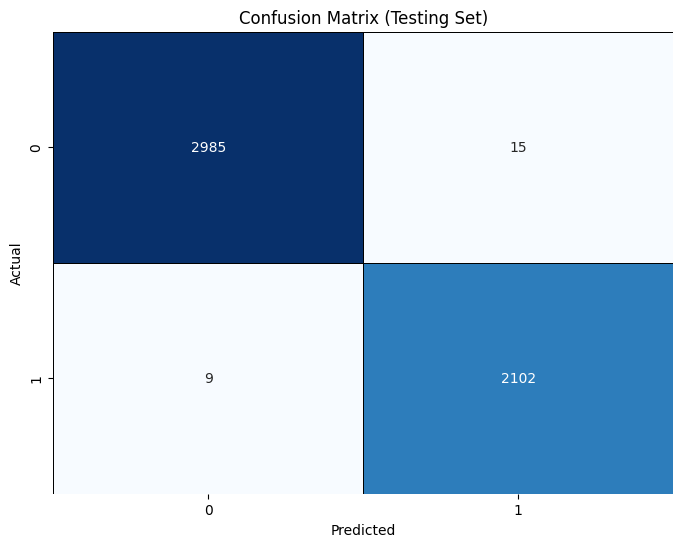


Example Prediction: [1]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


['money_laundering.pkl']

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import joblib

# Load the dataset
df = pd.read_csv("/inputtt.csv")  # Replace with your CSV file path

# Display basic information about the dataset
print("Dataset Overview:")
print(df.head())
print("\nDataset Description:")
print(df.describe())
print("\nDataset Info:")
df.info()

# Analyze the target column
print("\nTarget Value Counts:")
print(df["Is_laundering"].value_counts())

# Check for null and duplicate values
print("\nNull Values per Column:")
print(df.isnull().sum())
print("\nNumber of Duplicate Rows:", df.duplicated().sum())

# Separate the dataset into laundering and non-laundering cases
laundering = df[df["Is_laundering"] == 1]
not_laundering = df[df["Is_laundering"] == 0].sample(10000, random_state=1)

# Combine the selected data
data = pd.concat([laundering, not_laundering])
print("\nCombined Data Overview:")
print(data.head())

# Separate features and target
X = data.drop(columns=["Is_laundering", "Date", "Time", "Sender_account", "Receiver_account"])
y = data["Is_laundering"]

# Encode categorical variables
categorical_columns = X.select_dtypes(include=["object"]).columns
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter name
encoded_cats = encoder.fit_transform(X[categorical_columns])
joblib.dump(encoder, "encoder.pkl")  # Save the encoder for future use


# Combine encoded categorical and numeric data
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_columns))
numeric_df = X.drop(columns=categorical_columns).reset_index(drop=True)
final_df = pd.concat([encoded_df, numeric_df], axis=1)
print("\nTransformed DataFrame Shape:", final_df.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.30, random_state=42, stratify=y)
print("\nTraining and Testing Data Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)

# Train a Random Forest Classifier
model = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
model.fit(X_train, y_train)


# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)


roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

print(f"\nAccuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

# Display confusion matrix and classification report
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Testing Set)")
plt.show()

# Example prediction
example = {
    "amount": [1415.59],
    "Payment_currency": ["UK pounds"],
    "Received_currency": ["UK pounds"],
    "Sender_bank_location": ["UK"],
    "Receiver_bank_location": ["UK"],
    "Payment_type": ["Cash Deposit"],
    "Laundering_type": ["Normal_Plus_Mutual"]
}
example_df = pd.DataFrame(example)
example_encoded = encoder.transform(example_df[example_df.columns[1:]])
example_data = np.append(example_encoded, example["amount"])
prediction = model.predict(example_data.reshape(1, -1))
print("\nExample Prediction:", prediction)

# Save the trained model
joblib.dump(model, "money_laundering.pkl")


In [3]:
import numpy as np
import pandas as pd
import joblib

# Load the saved encoder and model
encoder = joblib.load("encoder.pkl")
model = joblib.load("money_laundering.pkl")

# Define new data for prediction
new_data = {
    "amount": [2603.3],  # Example numeric feature
    "Payment_currency": ["UK pounds"],  # Categorical feature
    "Received_currency": ["UK pounds"],  # Categorical feature
    "Sender_bank_location": ["UK"],  # Categorical feature
    "Receiver_bank_location": ["UK"],  # Categorical feature
    "Payment_type": ["Cash Deposit"],  # Categorical feature
    "Laundering_type": ["Smurfing"]  # Categorical feature
}

# Convert new data to a DataFrame
new_data_df = pd.DataFrame(new_data)

# Separate numeric and categorical features
numeric_features = new_data_df[["amount"]]
categorical_features = new_data_df.drop(columns=["amount"])

# Transform categorical features using the loaded encoder
encoded_categorical = encoder.transform(categorical_features)

# Combine numeric and encoded categorical features
final_features = np.hstack((encoded_categorical, numeric_features.values))

# Predict using the loaded model
prediction = model.predict(final_features)
prediction_proba = model.predict_proba(final_features)

# Output the prediction
print("Prediction (Is_laundering):", prediction[0])  # 1 for laundering, 0 for not laundering
print("Prediction Probabilities (Class Probabilities):", prediction_proba)


Prediction (Is_laundering): 1
Prediction Probabilities (Class Probabilities): [[0.13357887 0.86642113]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
